In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
from utils import *
from model import *
from trainer import *

from tqdm.notebook import tqdm
from torch.optim.adam import Adam
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/Variants/SIR/omicron/*.csv'
dic_files = Load_files.load_files(path, -14, -12)
data = dic_files['대구']
data

,stdDay,Susceptible,22D_Infected,22D_Recovered,22D_Dead,22D_alpha,22D_beta,22D_gamma,23A_Infected,23A_Recovered,23A_Dead,23A_alpha,23A_beta,23A_gamma
0,2022-12-19,1154500,7646.89,28392.09,32.73,0.470884,0.191027,0.000145,9.73,0.00,0.00,7.709827,0.000000,0.000000
1,2022-12-20,1150875,7925.02,29852.85,33.84,0.454658,0.172557,0.000233,45.98,0.00,0.00,1.632581,0.000000,0.000000
2,2022-12-21,1147259,8291.33,31220.37,35.69,0.385427,0.137623,0.000134,82.14,0.00,0.00,0.810531,0.000000,0.000000
3,2022-12-22,1144062,8683.70,32361.45,36.80,0.306706,0.122074,0.000170,114.11,0.00,0.00,0.486252,0.000000,0.000000
4,2022-12-23,1141405,8897.53,33421.50,38.28,0.319341,0.127748,0.000125,140.68,0.00,0.00,0.420776,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2023-04-30,1031603,503.31,104434.19,135.79,0.106662,0.063420,0.000000,1695.36,9178.20,10.14,0.106662,0.063420,0.000000
133,2023-05-01,1031481,494.57,104466.11,135.79,0.427119,0.164426,0.000384,1665.92,9285.72,10.14,0.427119,0.164426,0.000384
134,2023-05-02,1031001,504.26,104547.43,135.98,0.405137,0.161266,0.000377,1698.56,9559.64,10.78,0.405137,0.161266,0.000377
135,2023-05-03,1030537,510.91,104628.75,136.17,0.505227,0.147267,0.000000,1720.96,9833.56,11.42,0.505227,0.147267,0.000000


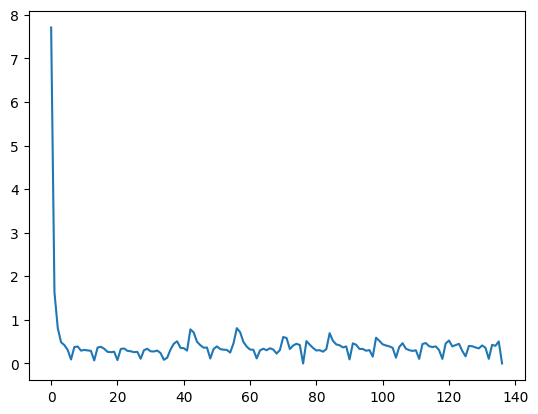

In [3]:
plt.plot(data['23A_alpha'])

In [5]:
path = 'hyperparameter/SIR/23A/*.pkl'
files = glob.glob(path)
dic_hyperparameter = {}
for file in files:
    dic_hyperparameter[file[23:-4]] = load_hyperparameter(file)
    
dic_hyperparameter

{'BiGRU': [348, 0.001, 50, 8, 64, 32, 0.25],
 'BiLSTM': [1611, 0.0001, 50, 1, 64, 8, 0.25],
 'BiRNN': [189, 0.0001, 20, 8, 64, 32, 0.25],
 'GRU': [2496, 0.0001, 20, 1, 64, 16, 0.25],
 'LSTM': [9310, 1e-05, 50, 1, 64, 16, 0.25],
 'RNN': [1293, 0.0001, 50, 1, 32, 8, 0.25],
 'seq2seq_BiGRU': [1165,
  0.001,
  50,
  1,
  32,
  16,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiLSTM': [997,
  0.001,
  50,
  2,
  32,
  32,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_BiRNN': [689, 0.001, 50, 4, 64, 8, 0.25, MSELoss()],
 'seq2seq_GRU': [2086,
  0.001,
  50,
  1,
  32,
  8,
  0.25,
  <function utils.criterion3(actual, predict)>],
 'seq2seq_LSTM': [602, 0.001, 20, 1, 64, 32, 0.25, MSELoss()],
 'seq2seq_RNN': [806,
  0.001,
  50,
  4,
  64,
  32,
  0.25,
  <function utils.criterion2(actual, predict)>]}

In [6]:
dic_model = load_model_multiple(dic_hyperparameter, 'SIR', '23A')

In [7]:
df = Prepare_df.processing(data, 'stdDay', '23A_alpha')

predicted_values = {}
num_model = 0
for name, state in dic_model.items():
    batch_size = dic_hyperparameter[name][4]
    if num_model < 6:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 68, 60, 1, batch_size, 'mto')
        label_y, predicted = predict_mto(state, df, x_ss, y_ms)
        predicted_values[name] = [label_y, predicted]
    else:
        x, y, x_ss, y_ms, train_loader, test_loader = Prepare_df.split_data(df, 62, 60, 7, batch_size, 'mtm')
        label_y, predicted, first_label_y, first_predicted, all_predicted = predict_mtm(state, df, x_ss, y_ms, 7, 0.5, device)
        predicted_values[name] = [label_y, predicted, first_label_y, first_predicted, all_predicted]
        
    
    num_model += 1

In [8]:
actual_data = predicted_values['RNN'][0]

0.1210332457838085


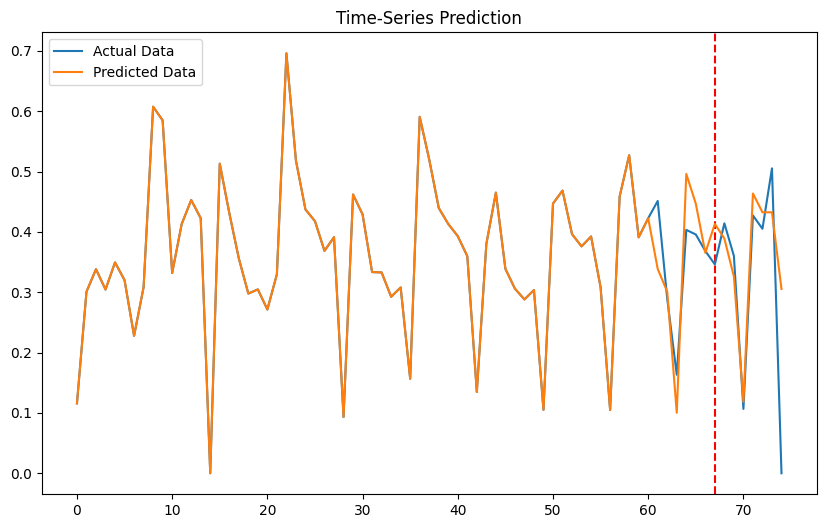

In [9]:
print(rmse(actual_data[-7:], predicted_values['RNN'][1][-7:]))
plotting(actual_data, predicted_values['RNN'][1], 67)

0.13356550710074958


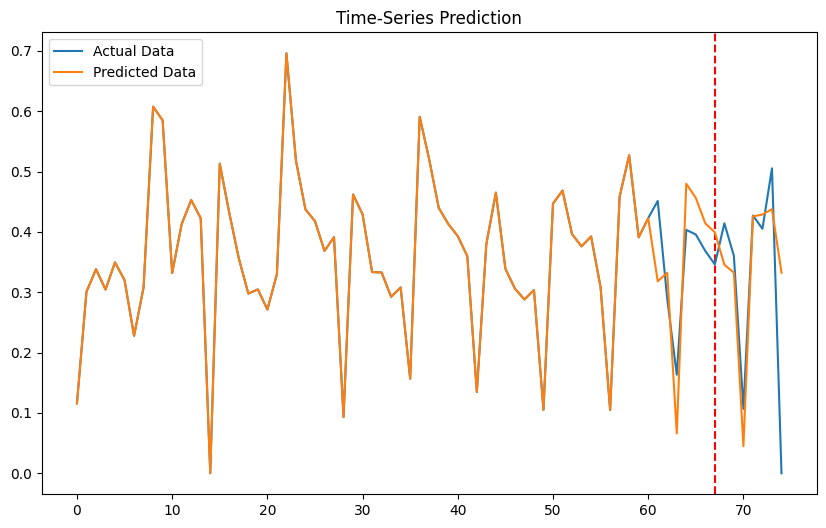

In [10]:
print(rmse(actual_data[-7:], predicted_values['LSTM'][1][-7:]))
plotting(actual_data, predicted_values['LSTM'][1], 67)

0.13977329967658936


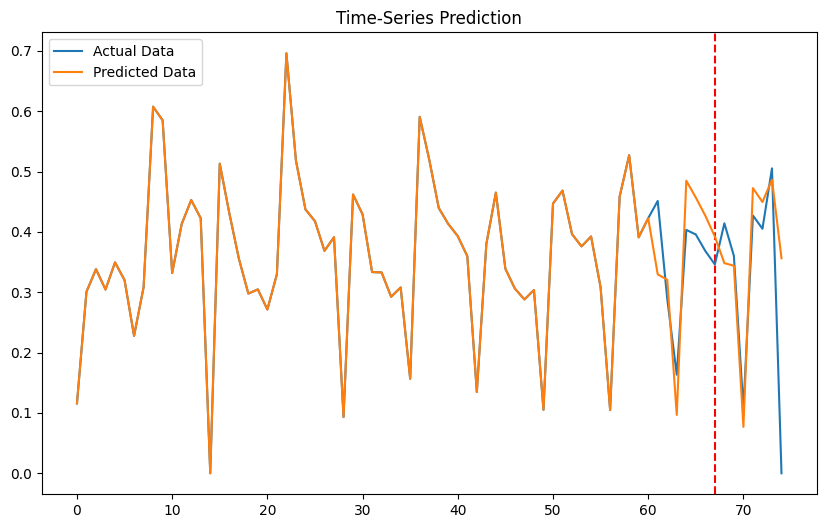

In [11]:
print(rmse(actual_data[-7:], predicted_values['GRU'][1][-7:]))
plotting(actual_data, predicted_values['GRU'][1], 67)

0.3632973287982427


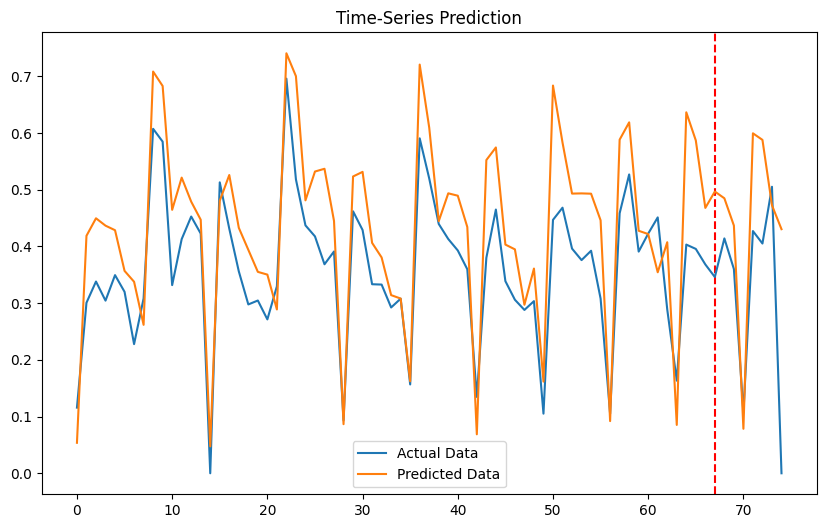

In [12]:
print(rmse(actual_data[0][-7:], predicted_values['BiRNN'][1][-7:]))
plotting(actual_data, predicted_values['BiRNN'][1], 67)

0.14039374914286062


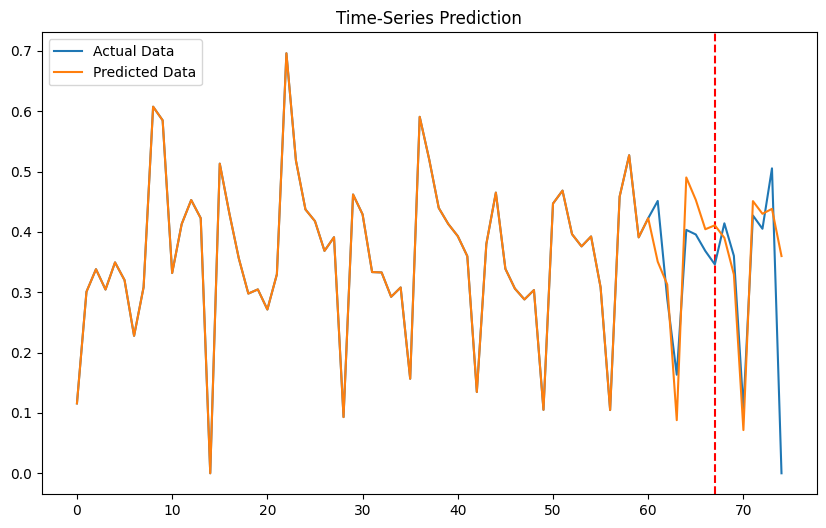

In [13]:
print(rmse(actual_data[-7:], predicted_values['BiLSTM'][1][-7:]))
plotting(actual_data, predicted_values['BiLSTM'][1], 67)

0.13206907074871146


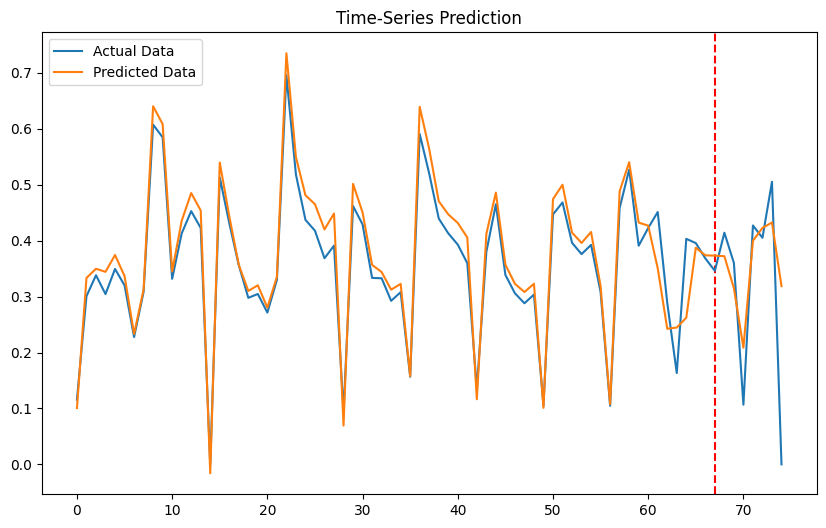

In [14]:
print(rmse(actual_data[-7:], predicted_values['BiGRU'][1][-7:]))
plotting(actual_data, predicted_values['BiGRU'][1], 67)

0.13984282509268817


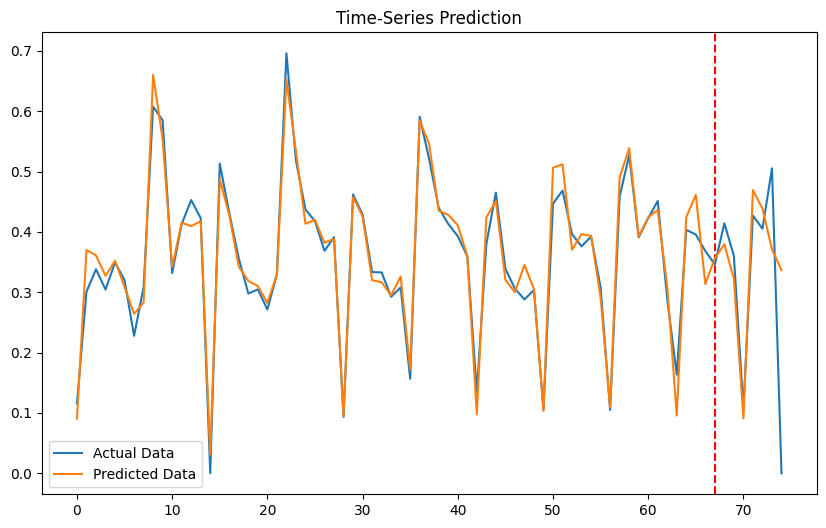

In [15]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_RNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_RNN'][4], 67)

0.16544967562139892


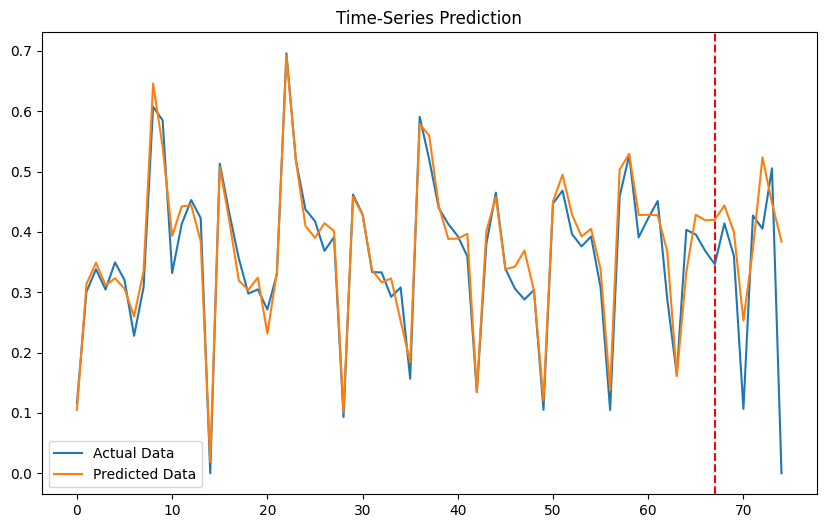

In [16]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_LSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_LSTM'][4], 67)

0.1362752328155305


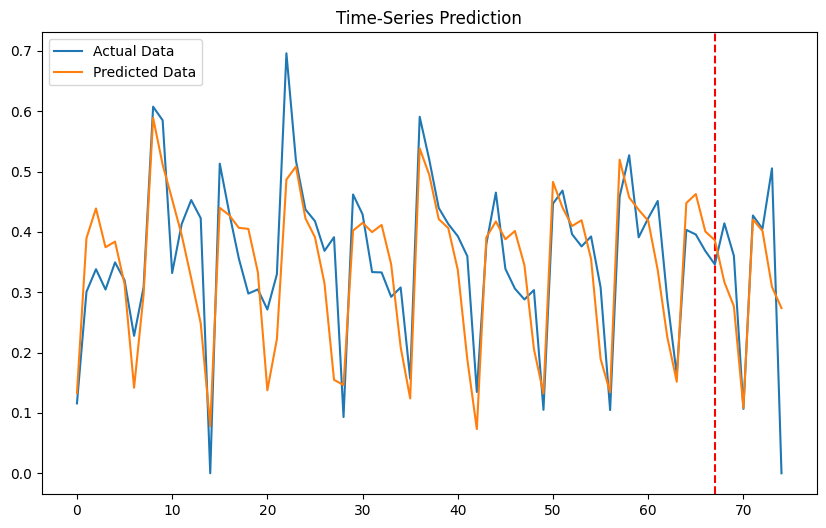

In [17]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_GRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_GRU'][4], 67)

0.1493017048456243


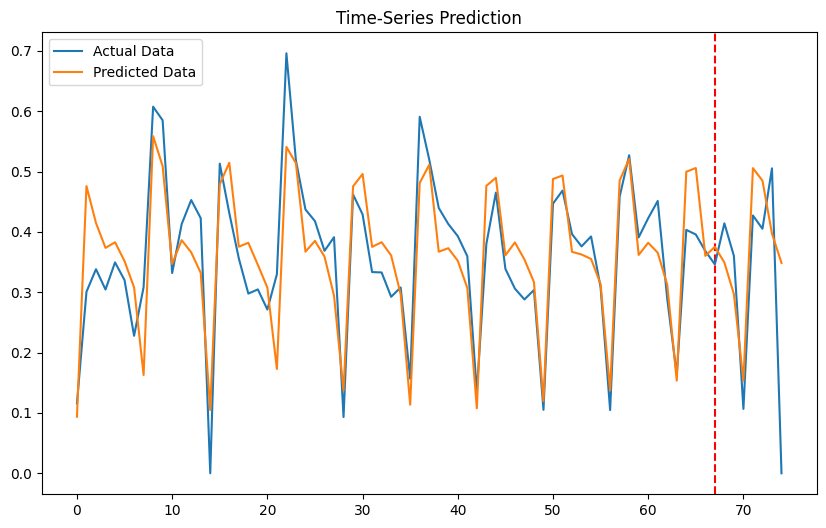

In [18]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiRNN'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiRNN'][4], 67)

0.15299004013041984


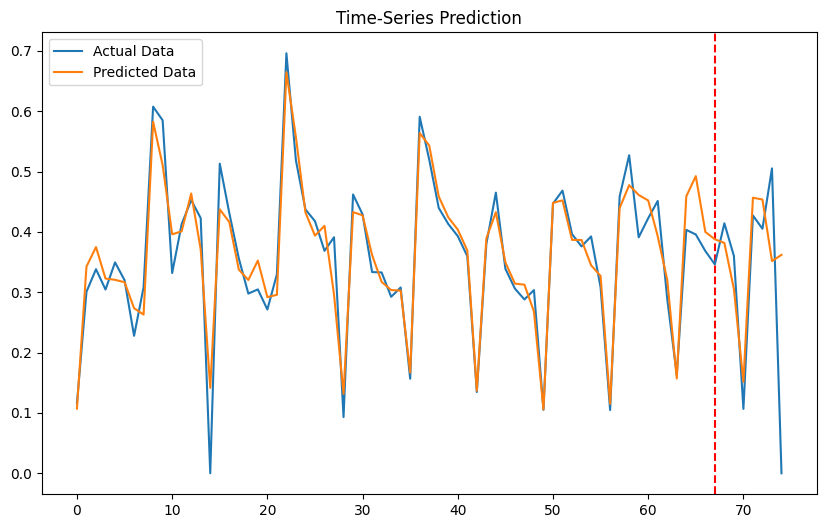

In [19]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiLSTM'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiLSTM'][4], 67)

0.13963998755652812


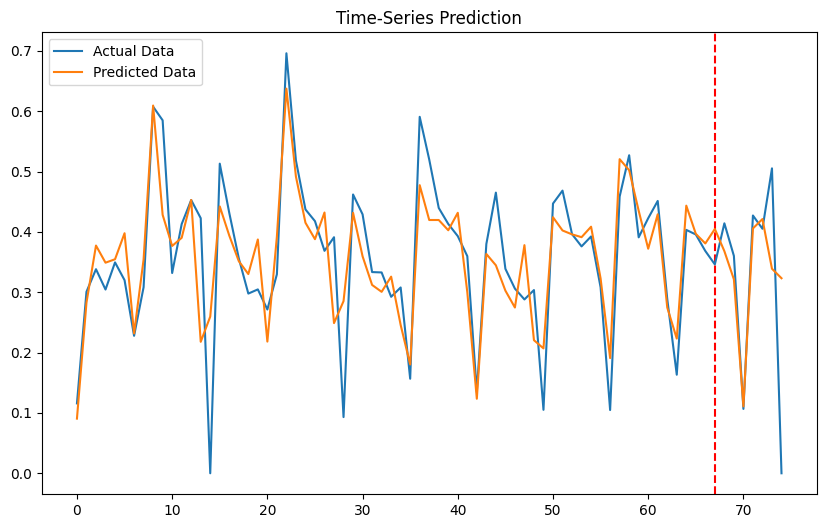

In [20]:
print(rmse(actual_data[-7:], predicted_values['seq2seq_BiGRU'][4][-7:]))
plotting(actual_data, predicted_values['seq2seq_BiGRU'][4], 67)

In [40]:
best_model = 'BiGRU'
datetime_index = data['stdDay'][-1*len(actual_data):]
df_predicted = pd.DataFrame()
df_predicted = pd.DataFrame(np.concatenate([actual_data, predicted_values[best_model][1]], axis = 1), index = datetime_index, columns = ['22D_origin', '22D_Predicted'])
df_predicted.to_csv(f'Data/Predicted/Variants/Infected/23A_{best_model}.csv')

In [41]:
df_predicted

,22D_origin,22D_Predicted
stdDay,,
2023-02-19,45.200001,44.622189
2023-02-20,18.080000,19.297462
2023-02-21,45.200001,53.596310
2023-02-22,48.159996,51.650913
2023-02-23,40.719997,41.296974
...,...,...
2023-04-30,253.439987,223.499100
2023-05-01,78.080002,117.221939
2023-05-02,307.199982,302.630615
